# Advanced Comparison Plots — Three Algorithms (Fast)
Twelve ready-to-run figures comparing all three algorithms on every plot.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

DEFAULT_M = 32
DEFAULT_K = 16
DEFAULT_N = 240
T_OUTER = 3
PRICE_STEP = 0.1
ALPHA = 0.5
BETA  = 0.8
LAMBDA_RISK = 0.4
DELTA_PRICE = 0.15
ELASTICITY  = 0.08

np.random.seed(23); random.seed(23)

def generate_instance(M=DEFAULT_M, K=DEFAULT_K, N=DEFAULT_N,
                      size_range=(0.6,1.8), cache_cap_range=(12.0,20.0),
                      price_bounds=(0.6,2.6), cache_cost_range=(0.4,1.2),
                      latency_range=(3.0,18.0), valuation_range=(1.0,6.0),
                      service_cap_range=(2000,4000), backhaul_cap_range=(800,1400)):
    S_f = np.random.uniform(*size_range, size=M)
    Smax = np.random.uniform(*cache_cap_range, size=K)
    p_lo = np.full(M, price_bounds[0]); p_hi = np.full(M, price_bounds[1])
    C_cache = np.random.uniform(*cache_cost_range, size=(M,K))
    l_ue = np.random.uniform(*latency_range, size=(N,K))
    V_uf = np.random.uniform(*valuation_range, size=(N,M))
    Gamma = np.random.uniform(*service_cap_range, size=K)
    Bcap = np.random.uniform(*backhaul_cap_range, size=K)
    kappa_f = np.random.uniform(0.6,1.4, size=M)
    eta_f   = np.random.uniform(0.4,1.0, size=M)
    R_u = np.ones(N)
    return dict(M=M,K=K,N=N,S_f=S_f,Smax=Smax,p_lo=p_lo,p_hi=p_hi,
                C_cache=C_cache,l_ue=l_ue,V_uf=V_uf,Gamma=Gamma,Bcap=Bcap,
                kappa_f=kappa_f, eta_f=eta_f, R_u=R_u)

def jains_index(x):
    per_edge = x.sum(axis=0).astype(float)
    s1 = (per_edge.sum()**2); s2 = (per_edge**2).sum(); K = len(per_edge)
    if s2 == 0: return 1.0
    return s1/(K*s2)

def utilities_tensor(V_uf, p, l_ue):
    return V_uf[:, :, None] - p[None, :, :] - l_ue[:, None, :]

def best_response_counts(x, U):
    N,M,K = U.shape[0],U.shape[1],U.shape[2]
    avail = x.astype(bool)[None,:,:]
    U_mask = np.where(avail, U, -1e12)
    U_flat = U_mask.reshape(N,-1)
    idx = np.argmax(U_flat, axis=1)
    maxU = U_flat[np.arange(N), idx]
    miss = maxU < -1e6
    f_star = idx // K; e_star = idx % K
    D = np.zeros((M,K), dtype=int)
    for u in range(N):
        if not miss[u]: D[f_star[u], e_star[u]] += 1
    return D, f_star, e_star, miss

def soft_choice(x, U, beta=BETA):
    mask = x.astype(bool)[None,:,:]
    U_mask = np.where(mask, U, -1e9)
    U_max  = U_mask.max(axis=(1,2), keepdims=True)
    Z = np.exp(beta*(U_mask - U_max))
    Z_sum = Z.sum(axis=(1,2), keepdims=True) + 1e-12
    return Z/Z_sum

# Alg-2: Pure Stackelberg (fast)
def cache_step_fast(inst, x, p, U):
    M,K = inst['M'],inst['K']; S_f,Smax = inst['S_f'],inst['Smax']; C_cache=inst['C_cache']
    avail = x.astype(bool)[None,:,:]
    U_best = np.where(avail, U, -1e12).max(axis=(1,2))
    gain = (U > U_best[:,None,None]).sum(axis=0)
    D, *_ = best_response_counts(x, U)
    weights = p*(D+0.5*gain) - C_cache
    new_x = x.copy()
    for e in range(K):
        order = np.argsort((weights[:,e]/(S_f+1e-12)))[::-1]
        cap = Smax[e]; new_x[:,e]=0
        for f in order:
            if weights[f,e]>0 and S_f[f]<=cap: new_x[f,e]=1; cap-=S_f[f]
    return new_x

def price_step_fast(inst, x, p, U, price_step=PRICE_STEP, trials=200):
    M,K = inst['M'],inst['K']; p_lo,p_hi = inst['p_lo'],inst['p_hi']; C_cache=inst['C_cache']
    pairs = [(f,e) for e in range(K) for f in range(M) if x[f,e]==1]
    if not pairs: return p
    trials = min(trials, len(pairs)); sample = random.sample(pairs, trials)
    D, *_ = best_response_counts(x, U)
    base = (p*D).sum() - (C_cache*x).sum()
    for (f,e) in sample:
        for d in (+price_step,-price_step):
            p_try = p.copy(); p_try[f,e] = np.clip(p[f,e]+d, p_lo[f], p_hi[f])
            U_try = utilities_tensor(inst['V_uf'], p_try, inst['l_ue'])
            D_try, *_ = best_response_counts(x, U_try)
            util = (p_try*D_try).sum() - (C_cache*x).sum()
            if util > base + 1e-9: p,U,D,base = p_try,U_try,D_try,util
    return p

def run_alg2_fast(inst, T=T_OUTER, price_step=PRICE_STEP):
    M,K = inst['M'],inst['K']
    p = np.tile(inst['p_hi'], (K,1)).T; x = np.zeros((M,K), dtype=int)
    hist = {"U_L":[], "hit_ratio":[], "mean_latency":[], "iters":0}
    for _ in range(T):
        U = utilities_tensor(inst['V_uf'], p, inst['l_ue'])
        D, f_star, e_star, miss = best_response_counts(x, U)
        hits = D.sum(); served = (~miss).sum()
        ml = float(inst['l_ue'][np.arange(inst['N'])[~miss], e_star[~miss]].mean()) if served>0 else 0.0
        U_L = float((p*D).sum() - (inst['C_cache']*x).sum())
        hist['U_L'].append(U_L); hist['hit_ratio'].append(hits/max(inst['N'],1)); hist['mean_latency'].append(ml)
        x = cache_step_fast(inst, x, p, U)
        U = utilities_tensor(inst['V_uf'], p, inst['l_ue'])
        p = price_step_fast(inst, x, p, U, price_step=price_step)
    hist['iters']=T
    U = utilities_tensor(inst['V_uf'], p, inst['l_ue']); D, *_ = best_response_counts(x, U)
    return x,p,D,hist

# Alg-1: GenAI+RAG (fast)
def simulate_rag(M,K, boost_max=0.5):
    boost = np.random.uniform(0.0, boost_max, size=(M,K))
    cap   = np.random.uniform(1.6,2.4, size=M)
    return boost, cap

def simulate_genai(M,K, sigma_max=0.4):
    mu    = np.random.uniform(0.4,2.0, size=(M,K))
    sigma = np.random.uniform(0.05, sigma_max, size=(M,K))
    return mu, sigma

def cache_step_genai_fast(inst, x, p, mu_rob, U, alpha=ALPHA):
    M,K = inst['M'],inst['K']; S_f,Smax = inst['S_f'],inst['Smax']; C_cache=inst['C_cache']
    pi = soft_choice(x, U, beta=BETA); D_beh = (inst['R_u'][:,None,None]*pi).sum(axis=0)
    avail = x.astype(bool)[None,:,:]; U_best = np.where(avail, U, -1e12).max(axis=(1,2))
    gain = (U > U_best[:,None,None]).sum(axis=0)
    Dtil = alpha*mu_rob + (1-alpha)*(D_beh + 0.5*gain)
    weights = p*Dtil - C_cache
    new_x = x.copy()
    for e in range(K):
        order = np.argsort((weights[:,e]/(S_f+1e-12)))[::-1]
        cap=Smax[e]; new_x[:,e]=0
        for f in order:
            if weights[f,e]>0 and S_f[f]<=cap: new_x[f,e]=1; cap-=S_f[f]
    return new_x

def price_step_genai_fast(inst, x, p, mu_bar, U, alpha=ALPHA, price_step=PRICE_STEP):
    M,K = inst['M'],inst['K']; p_lo,p_hi = inst['p_lo'],inst['p_hi']; C_cache=inst['C_cache']
    pairs = [(f,e) for e in range(K) for f in range(M) if x[f,e]==1]
    if not pairs: return p
    sample = random.sample(pairs, min(200, len(pairs)))
    pi = soft_choice(x, U, beta=BETA)
    D_beh = (inst['R_u'][:,None,None]*pi).sum(axis=0)
    D_tilde = alpha*mu_bar + (1-alpha)*D_beh
    base = (p*D_tilde).sum() - (C_cache*x).sum()
    for (f,e) in sample:
        for d in (+price_step,-price_step):
            p_try = p.copy(); p_try[f,e] = np.clip(p[f,e]+d, p_lo[f], p_hi[f])
            U_try = utilities_tensor(inst['V_uf'], p_try, inst['l_ue'])
            pi_t  = soft_choice(x, U_try, beta=BETA)
            D_beh_t = (inst['R_u'][:,None,None]*pi_t).sum(axis=0)
            D_tilde_t = alpha*mu_bar + (1-alpha)*D_beh_t
            util = (p_try*D_tilde_t).sum() - (C_cache*x).sum()
            if util > base + 1e-9: p,U,base = p_try,U_try,util
    return p

def run_alg1_fast(inst, T=T_OUTER, alpha=ALPHA, lambda_risk=LAMBDA_RISK, sigma_max=0.4, boost_max=0.5, price_step=PRICE_STEP):
    M,K = inst['M'],inst['K']
    boost, cap = simulate_rag(M,K, boost_max=boost_max)
    mu, sigma  = simulate_genai(M,K, sigma_max=sigma_max)
    mu_bar = mu*(1+boost); mu_rob = mu_bar - lambda_risk*sigma
    p = np.tile(np.minimum(inst['p_hi'], cap), (K,1)).T; x = np.zeros((M,K), dtype=int)
    hist = {"U_L":[], "hit_ratio":[], "mean_latency":[], "iters":0}
    for _ in range(T):
        U = utilities_tensor(inst['V_uf'], p, inst['l_ue'])
        pi = soft_choice(x, U, beta=BETA); D_beh = (inst['R_u'][:,None,None]*pi).sum(axis=0)
        D_tilde = alpha*mu_bar + (1-alpha)*D_beh
        hits = D_beh.sum()
        U_mask = np.where(x.astype(bool)[None,:,:], U, -1e9)
        idx = np.argmax(U_mask.reshape(inst['N'],-1), axis=1); e_star = idx % inst['K']
        ml = float(inst['l_ue'][np.arange(inst['N']), e_star].mean())
        U_L = float((p*D_tilde).sum() - (inst['C_cache']*x).sum())
        hist['U_L'].append(U_L); hist['hit_ratio'].append(hits/max(inst['N'],1)); hist['mean_latency'].append(ml)
        x = cache_step_genai_fast(inst, x, p, mu_rob, U, alpha=alpha)
        U = utilities_tensor(inst['V_uf'], p, inst['l_ue'])
        p = price_step_genai_fast(inst, x, p, mu_bar, U, alpha=alpha, price_step=price_step)
    hist['iters']=T
    U = utilities_tensor(inst['V_uf'], p, inst['l_ue'])
    pi = soft_choice(x, U, beta=BETA); D_beh = (inst['R_u'][:,None,None]*pi).sum(axis=0)
    D_tilde = alpha*mu_bar + (1-alpha)*D_beh
    return x,p,D_tilde,hist

# Alg-3: Heuristic (fast)
def run_alg3_fast(inst, delta_price=DELTA_PRICE):
    M,K = inst['M'],inst['K']
    p = np.full((M,K), 1.8); x = np.zeros((M,K), dtype=int)
    S_f,Smax = inst['S_f'],inst['Smax']; C_cache=inst['C_cache']
    U = utilities_tensor(inst['V_uf'], p, inst['l_ue'])
    D_eff = (U > 0).sum(axis=0).astype(float)
    for e in range(K):
        rho = (p[:,e]*D_eff[:,e] - C_cache[:,e])/(S_f+1e-12)
        order = np.argsort(rho)[::-1]; cap = Smax[e]
        for f in order:
            if rho[f]>0 and S_f[f] <= cap: x[f,e]=1; cap-=S_f[f]
    for e in range(K):
        for f in range(M):
            if x[f,e]!=1: continue
            best_p = p[f,e]; best_U = best_p*D_eff[f,e]-C_cache[f,e]
            for dp in (-delta_price, +delta_price):
                pt = max(inst['p_lo'][f], min(inst['p_hi'][f], best_p+dp))
                Dt = D_eff[f,e]*(1 - 0.08*(pt-best_p))
                Ut = pt*Dt - C_cache[f,e]
                if Ut>best_U: best_p, best_U = pt, Ut
            p[f,e]=best_p
    U_L = (p*(D_eff*x)).sum() - (C_cache*x).sum()
    hit_ratio = (D_eff*x).sum()/max(inst['N'],1)
    ml = float(inst['l_ue'].mean())
    hist = {"U_L":[float(U_L)], "hit_ratio":[float(hit_ratio)], "mean_latency":[ml], "iters":1}
    return x,p,(D_eff*x),hist

def RUN_ALG1(inst, **kw): return run_alg1_fast(inst, **kw)
def RUN_ALG2(inst, **kw): return run_alg2_fast(inst, **kw)
def RUN_ALG3(inst, **kw): return run_alg3_fast(inst, **kw)

print('Algorithms loaded.')

Algorithms loaded.


In [ ]:
# 12 comparison plots (10 requested + 2 optional)

def plot_utility_vs_users(Ns=(120,180,240,300)):
    y1,y2,y3=[],[],[]
    for N in Ns:
        inst = generate_instance(N=N)
        _,_,_,h1 = RUN_ALG1(inst)
        _,_,_,h2 = RUN_ALG2(inst)
        _,_,_,h3 = RUN_ALG3(inst)
        y1.append(h1['U_L'][-1]); y2.append(h2['U_L'][-1]); y3.append(h3['U_L'][-1])
    plt.figure(); plt.plot(Ns,y1,marker='o',label='Alg-1'); plt.plot(Ns,y2,marker='o',label='Alg-2'); plt.plot(Ns,y3,marker='o',label='Alg-3')
    plt.xlabel('Users (N)'); plt.ylabel('Leader Utility'); plt.title('Utility vs Users'); plt.grid(True); plt.legend(); plt.show()

def plot_hit_ratio_vs_cache(caps=(10.0,12.0,15.0,18.0)):
    y1,y2,y3=[],[],[]
    for cap in caps:
        inst = generate_instance(cache_cap_range=(cap,cap))
        _,_,_,h1 = RUN_ALG1(inst)
        _,_,_,h2 = RUN_ALG2(inst)
        _,_,_,h3 = RUN_ALG3(inst)
        y1.append(h1['hit_ratio'][-1]); y2.append(h2['hit_ratio'][-1]); y3.append(h3['hit_ratio'][-1])
    plt.figure(); plt.plot(caps,y1,marker='s',label='Alg-1'); plt.plot(caps,y2,marker='s',label='Alg-2'); plt.plot(caps,y3,marker='s',label='Alg-3')
    plt.xlabel('Cache Capacity per Edge'); plt.ylabel('Hit Ratio'); plt.title('Hit Ratio vs Cache Capacity'); plt.grid(True); plt.legend(); plt.show()

def plot_latency_vs_edges(Ks=(8,12,16,20)):
    y1,y2,y3=[],[],[]
    for K in Ks:
        inst = generate_instance(K=K)
        _,_,_,h1 = RUN_ALG1(inst)
        _,_,_,h2 = RUN_ALG2(inst)
        _,_,_,h3 = RUN_ALG3(inst)
        y1.append(h1['mean_latency'][-1]); y2.append(h2['mean_latency'][-1]); y3.append(h3['mean_latency'][-1])
    plt.figure(); plt.plot(Ks,y1,marker='d',label='Alg-1'); plt.plot(Ks,y2,marker='d',label='Alg-2'); plt.plot(Ks,y3,marker='d',label='Alg-3')
    plt.xlabel('Edges (K)'); plt.ylabel('Mean Latency'); plt.title('Latency vs Edges'); plt.grid(True); plt.legend(); plt.show()

def plot_energy_vs_size_variability(scales=(1.0,1.25,1.5,1.75)):
    a,b=1.0,2.0
    y1,y2,y3=[],[],[]
    for s in scales:
        inst = generate_instance(size_range=(0.6*s, 1.8*s))
        _,_,D1,_ = RUN_ALG1(inst)
        _,_,D2,_ = RUN_ALG2(inst)
        _,_,D3,_ = RUN_ALG3(inst)
        for acc, D in ((y1,D1),(y2,D2),(y3,D3)):
            served = D.sum(); misses = inst['N'] - min(inst['N'], served)
            acc.append(a*served + b*misses)
    plt.figure(); plt.plot(scales,y1,marker='^',label='Alg-1'); plt.plot(scales,y2,marker='^',label='Alg-2'); plt.plot(scales,y3,marker='^',label='Alg-3')
    plt.xlabel('Content Size Scale'); plt.ylabel('Energy Proxy'); plt.title('Energy vs Content Size Variability'); plt.grid(True); plt.legend(); plt.show()

def plot_convergence_vs_alpha(alphas=(0.2,0.4,0.6,0.8)):
    y1,y2,y3=[],[],[]
    for a_ in alphas:
        inst = generate_instance()
        _,_,_,h1 = RUN_ALG1(inst, alpha=a_)
        _,_,_,h2 = RUN_ALG2(inst)
        _,_,_,h3 = RUN_ALG3(inst)
        y1.append(h1['iters']); y2.append(h2['iters']); y3.append(h3['iters'])
    plt.figure(); plt.plot(alphas,y1,marker='o',label='Alg-1'); plt.plot(alphas,y2,marker='o',label='Alg-2'); plt.plot(alphas,y3,marker='o',label='Alg-3')
    plt.xlabel('Blend α'); plt.ylabel('Outer Iterations'); plt.title('Convergence vs α'); plt.grid(True); plt.legend(); plt.show()

def plot_rmse_vs_sigma(sigmas=(0.10,0.20,0.30,0.40)):
    r1,r2,r3=[],[],[]
    for s in sigmas:
        a = generate_instance(); b = generate_instance()
        a['V_uf'] = a['V_uf'] + np.random.normal(0, s, size=a['V_uf'].shape)
        _,_,D1,_ = RUN_ALG1(a, sigma_max=s); _,_,D1b,_ = RUN_ALG1(b, sigma_max=s)
        _,_,D2,_ = RUN_ALG2(a);              _,_,D2b,_ = RUN_ALG2(b)
        _,_,D3,_ = RUN_ALG3(a);              _,_,D3b,_ = RUN_ALG3(b)
        r1.append(float(np.sqrt(np.mean((D1-D1b)**2)))); r2.append(float(np.sqrt(np.mean((D2-D2b)**2)))); r3.append(float(np.sqrt(np.mean((D3-D3b)**2))))
    plt.figure(); plt.plot(sigmas,r1,marker='o',label='Alg-1'); plt.plot(sigmas,r2,marker='o',label='Alg-2'); plt.plot(sigmas,r3,marker='o',label='Alg-3')
    plt.xlabel('Uncertainty σ'); plt.ylabel('RMSE(D)'); plt.title('Prediction Error vs Uncertainty'); plt.grid(True); plt.legend(); plt.show()

def plot_fairness_vs_event_boost(boosts=(0.0,0.2,0.4,0.6)):
    y1,y2,y3=[],[],[]
    for b in boosts:
        inst = generate_instance()
        x1,_,_,_ = RUN_ALG1(inst, boost_max=b)
        x2,_,_,_ = RUN_ALG2(inst)
        x3,_,_,_ = RUN_ALG3(inst)
        y1.append(jains_index(x1)); y2.append(jains_index(x2)); y3.append(jains_index(x3))
    plt.figure(); plt.plot(boosts,y1,marker='s',label='Alg-1'); plt.plot(boosts,y2,marker='s',label='Alg-2'); plt.plot(boosts,y3,marker='s',label='Alg-3')
    plt.xlabel('Event Boost Magnitude'); plt.ylabel("Jain's Fairness Index"); plt.title('Fairness vs Event Boost'); plt.grid(True); plt.legend(); plt.show()

def plot_utility_vs_price_step(steps=(0.05,0.1,0.15,0.2)):
    y1,y2,y3=[],[],[]
    for st in steps:
        inst = generate_instance()
        _,_,_,h1 = RUN_ALG1(inst, price_step=st)
        _,_,_,h2 = RUN_ALG2(inst, price_step=st)
        _,_,_,h3 = RUN_ALG3(inst)  # heuristic internal delta
        y1.append(h1['U_L'][-1]); y2.append(h2['U_L'][-1]); y3.append(h3['U_L'][-1])
    plt.figure(); plt.plot(steps,y1,marker='^',label='Alg-1'); plt.plot(steps,y2,marker='^',label='Alg-2'); plt.plot(steps,y3,marker='^',label='Alg-3')
    plt.xlabel('Price Step Size Δp'); plt.ylabel('Leader Utility'); plt.title('Utility vs Price Step'); plt.grid(True); plt.legend(); plt.show()

def plot_hit_ratio_vs_latency_range(uppers=(12.0,16.0,20.0,24.0)):
    y1,y2,y3=[],[],[]
    for up in uppers:
        inst = generate_instance(latency_range=(3.0, up))
        _,_,_,h1 = RUN_ALG1(inst)
        _,_,_,h2 = RUN_ALG2(inst)
        _,_,_,h3 = RUN_ALG3(inst)
        y1.append(h1['hit_ratio'][-1]); y2.append(h2['hit_ratio'][-1]); y3.append(h3['hit_ratio'][-1])
    plt.figure(); plt.plot(uppers,y1,marker='o',label='Alg-1'); plt.plot(uppers,y2,marker='o',label='Alg-2'); plt.plot(uppers,y3,marker='o',label='Alg-3')
    plt.xlabel('Latency Disutility Upper Bound'); plt.ylabel('Hit Ratio'); plt.title('Hit Ratio vs Latency Range'); plt.grid(True); plt.legend(); plt.show()

def plot_energy_vs_lambda(lambdas=(0.1,0.3,0.5,0.7)):
    a,b=1.0,2.0; y1,y2,y3=[],[],[]
    for lam in lambdas:
        inst = generate_instance()
        _,_,D1,_ = RUN_ALG1(inst, lambda_risk=lam)
        _,_,D2,_ = RUN_ALG2(inst)
        _,_,D3,_ = RUN_ALG3(inst)
        for acc, D in ((y1,D1),(y2,D2),(y3,D3)):
            served = D.sum(); misses = inst['N'] - min(inst['N'], served)
            acc.append(a*served + b*misses)
    plt.figure(); plt.plot(lambdas,y1,marker='d',label='Alg-1'); plt.plot(lambdas,y2,marker='d',label='Alg-2'); plt.plot(lambdas,y3,marker='d',label='Alg-3')
    plt.xlabel('Robustness λ'); plt.ylabel('Energy Proxy'); plt.title('Energy vs Robustness'); plt.grid(True); plt.legend(); plt.show()

def plot_latency_energy_pareto(caps=(10.0,12.0,15.0,18.0)):
    a,b=1.0,2.0; pts1,pts2,pts3=[],[],[]
    for cap in caps:
        inst = generate_instance(cache_cap_range=(cap,cap))
        x1,p1,D1,h1 = RUN_ALG1(inst)
        x2,p2,D2,h2 = RUN_ALG2(inst)
        x3,p3,D3,h3 = RUN_ALG3(inst)
        for bag, D, h in ((pts1,D1,h1),(pts2,D2,h2),(pts3,D3,h3)):
            served = D.sum(); misses = inst['N'] - min(inst['N'], served)
            E = a*served + b*misses
            bag.append((h['mean_latency'][-1], E))
    plt.figure()
    plt.scatter([x for x,_ in pts1], [y for _,y in pts1], label='Alg-1', marker='o')
    plt.scatter([x for x,_ in pts2], [y for _,y in pts2], label='Alg-2', marker='s')
    plt.scatter([x for x,_ in pts3], [y for _,y in pts3], label='Alg-3', marker='^')
    plt.xlabel('Mean Latency'); plt.ylabel('Energy Proxy'); plt.title('Latency–Energy Pareto'); plt.grid(True); plt.legend(); plt.show()

def plot_profit_per_edge_vs_bandwidth(bands=(1800,2200,2600,3000)):
    y1,y2,y3=[],[],[]
    for g in bands:
        inst = generate_instance(service_cap_range=(g,g))
        x1,p1,D1,h1 = RUN_ALG1(inst)
        x2,p2,D2,h2 = RUN_ALG2(inst)
        x3,p3,D3,h3 = RUN_ALG3(inst)
        prof1 = float((p1*D1).sum() - (inst['C_cache']*x1).sum())/inst['K']
        prof2 = float((p2*D2).sum() - (inst['C_cache']*x2).sum())/inst['K']
        prof3 = float((p3*D3).sum() - (inst['C_cache']*x3).sum())/inst['K']
        y1.append(prof1); y2.append(prof2); y3.append(prof3)
    plt.figure(); plt.plot(bands,y1,marker='o',label='Alg-1'); plt.plot(bands,y2,marker='o',label='Alg-2'); plt.plot(bands,y3,marker='o',label='Alg-3')
    plt.xlabel('Bandwidth Γ_e (per edge)'); plt.ylabel('Profit per Edge'); plt.title('Profit per Edge vs Bandwidth'); plt.grid(True); plt.legend(); plt.show()

print('Advanced plotting functions loaded.')


Advanced plotting functions loaded.


## Quick Start
Uncomment any of the following to render the plots.

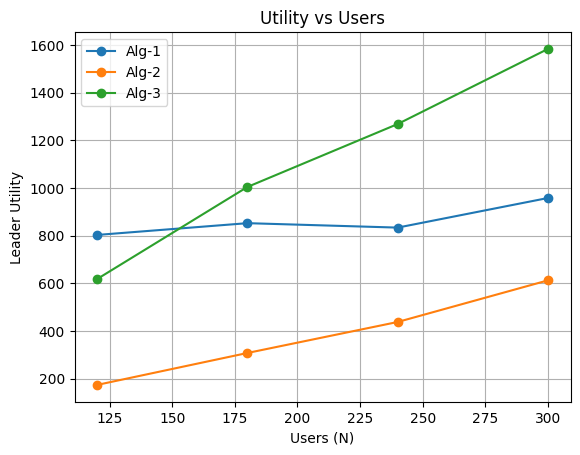

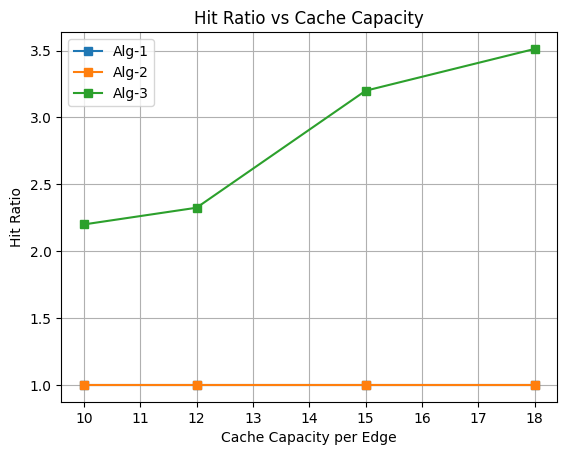

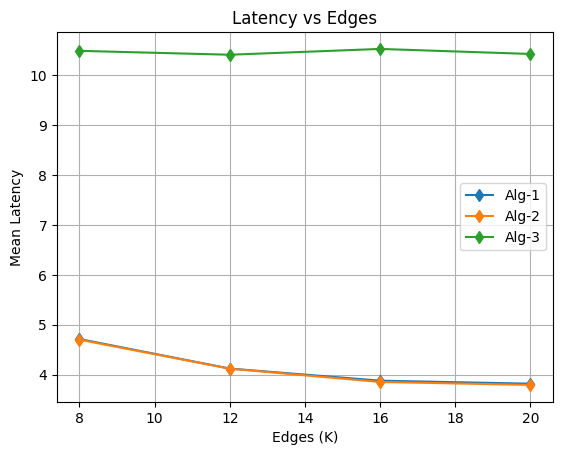

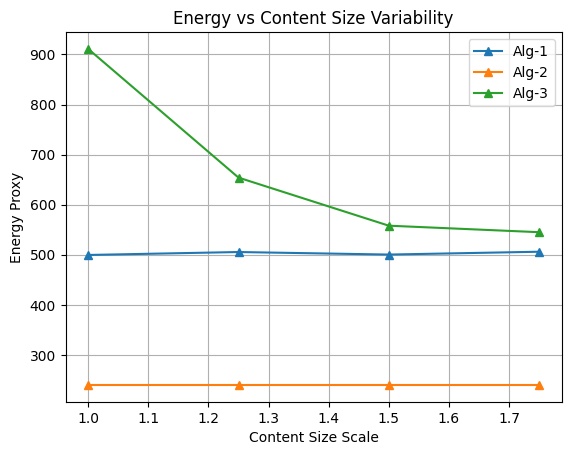

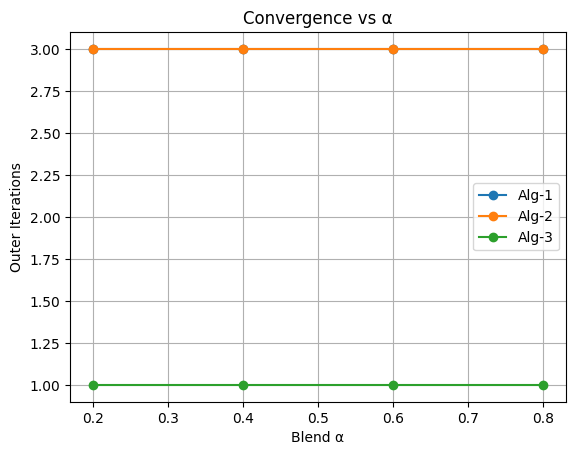

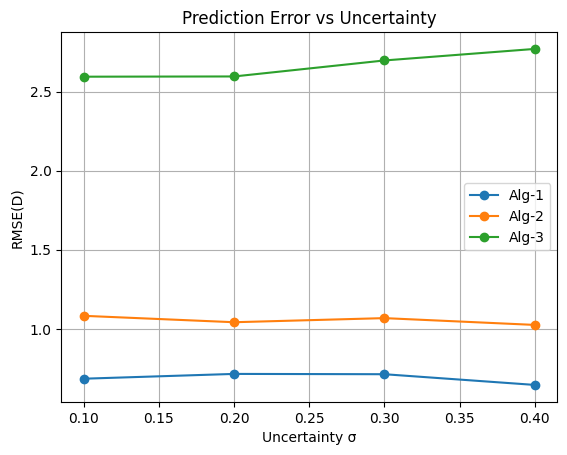

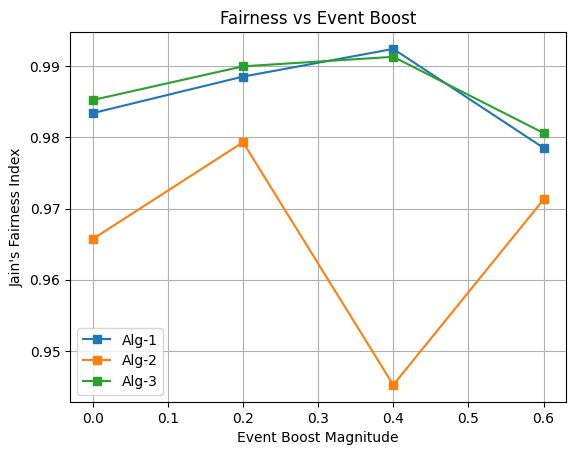

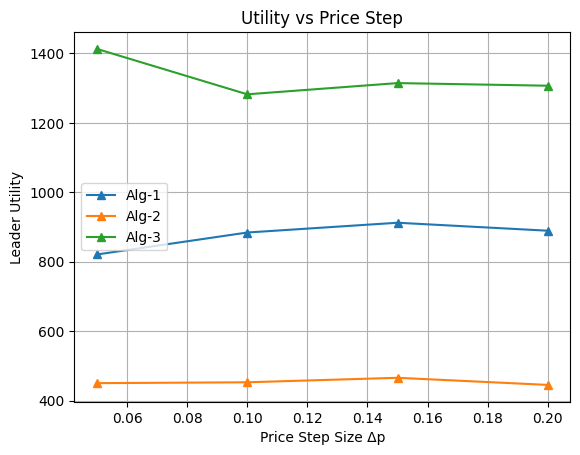

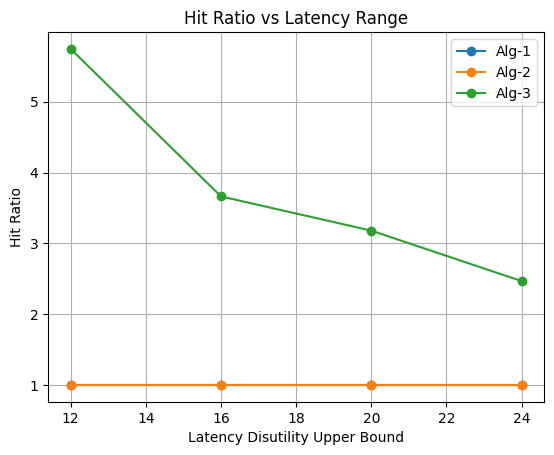

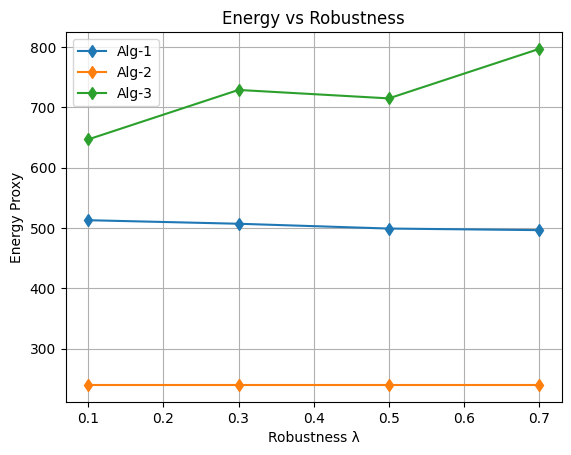

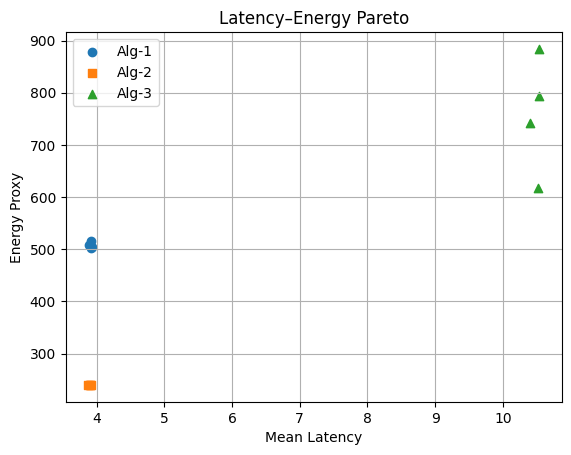

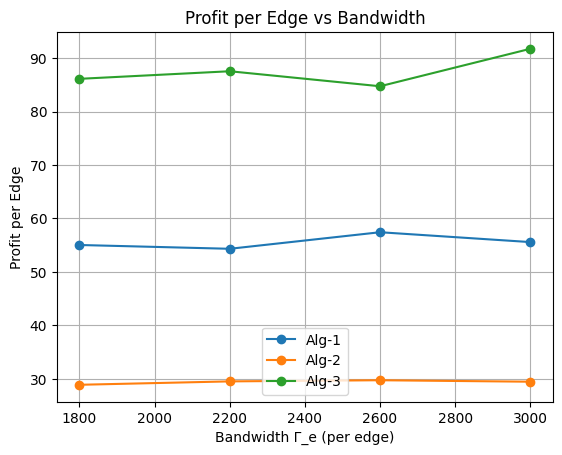

In [ ]:
  plot_utility_vs_users()
  plot_hit_ratio_vs_cache()
  plot_latency_vs_edges()
  plot_energy_vs_size_variability()
  plot_convergence_vs_alpha()
  plot_rmse_vs_sigma()
  plot_fairness_vs_event_boost()
  plot_utility_vs_price_step()
  plot_hit_ratio_vs_latency_range()
  plot_energy_vs_lambda()
  plot_latency_energy_pareto()
  plot_profit_per_edge_vs_bandwidth()
